In [3]:
""" iLINCS Numbers

Here the aim is to come up with preliminary numbers for the iLINCS project - 
to show how much data we have.

Structure:
    a) Load signature data
    b) Numbers for datasets
    c) Numbers for factors
    d) Numbers for conditions
"""

' iLINCS Numbers\n\nHere the aim is to come up with preliminary numbers for the iLINCS project - \nto show how much data we have.\n\nStructure:\n    a) Load signature data\n    b) Numbers for datasets\n    c) Numbers for factors\n    d) Numbers for conditions\n'

## a) Load signature data

In [1]:
"""iLINCS

The exercise here is to quantify HOW many diseases are there for which we have "disease" signatures

Structure:
    1. Imports, Variables, Functions
    2. Retrieve MeSH terms
    3. Retrieve Signature Datasets
    4. Maps MeSH terms to Signatures
    5. Plot Results
"""

# 1. Imports, Variables, Functions
# imports
import requests, json, re
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
from Bio import Entrez
import logging
import time
from collections import Counter
import matplotlib.cm as cm

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)


# variables
Entrez.email = "dylandaltonsub@gmail.com"
base_url = "http://www.ilincs.org/api"
doi_data_path = "../data/DiseaseOntology/doid.obo"
mesh_file_path = "../data/MeSH/desc2023.xml"
d_dataset_2_mesh = dict()
d_signature_2_mesh = dict()
d_mesh_symbol_2_term = dict()
filter_criteria = lambda s: (s["factor"] == "disease.state") and (
    "normal" in s["level2"] or "control" in s["level2"] or "healthy" in s["level2"]
)


# functions
def fetch_disease_signatures(factor):
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def extract_disease_names_from_obo(file_path):
    """
    Extracts disease names from an OBO formatted file.

    Args:
    - file_path (str): Path to the OBO file.

    Returns:
    - List[str]: A list of disease names.
    """

    # Open and read the content of the OBO file
    with open(file_path, "r") as f:
        content = f.read()

    # The OBO format divides entries using '[Term]'. We split the content based on this to get individual entries.
    terms = content.split("[Term]")

    disease_names = []  # List to store extracted disease names

    # Iterate over each term/entry
    for term in terms:
        # Use a regular expression to search for the line that starts with 'name: '
        # This line contains the name of the disease.
        match = re.search(r"name: (.+)", term)

        # If a match is found (i.e., the term has a name), extract it and add to the list
        if match:
            disease_name = match.group(
                1
            )  # The actual name is captured in the first group of the regex
            disease_names.append(disease_name)

    return disease_names


def parse_mesh_data(file_path):
    """Parse MeSH XML data and extract disease terms."""
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract disease terms
    disease_terms = []
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        disease_terms.append(term)

    return disease_terms, None


def parse_mesh_data(file_path):
    """Parse MeSH XML data and extract disease terms.

    Retrieve the Botom-Most disease terms which contain the most specific
    information for a disease.

    Parameters:
        file_path: str()

    Return:
        disease_terms: list()
        list_tree_numbers: list()"""
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Extract disease terms
    disease_terms = list()
    list_tree_numbers = list()
    for descriptor in root.findall("DescriptorRecord"):
        # Check if the term is under the category of diseases
        tree_numbers = descriptor.findall("TreeNumberList/TreeNumber")
        for tree_number in tree_numbers:
            # This is a basic check for TreeNumbers starting with 'C' which usually denotes diseases in MeSH
            # You might need to adjust this based on the specific structure of your XML file
            if tree_number.text.startswith("C"):
                list_tree_numbers.append(tree_number.text)
                term = descriptor.find("DescriptorName/String").text
                disease_terms.append(term)
                break  # Break after adding the term to avoid duplicates

    return disease_terms, list_tree_numbers


def extract_pmid_from_publink(publink):
    """Extract the PubMed ID from the provided publink."""
    pmid_match = re.search(r"term=(\d+)\[UID\]", publink)
    if pmid_match:
        return pmid_match.group(1)
    return None


def get_pmid_from_geo_via_eutils(geo_id):
    # Use elink to establish links between GEO and PubMed databases
    handle = Entrez.elink(dbfrom="gds", db="pubmed", id=geo_id[3:])
    record = Entrez.read(handle)
    handle.close()

    # Extract the PMID from the linked records
    # if it has LinkSetDb report else return None
    if len(record[0]["LinkSetDb"]) > 0:
        return record[0]["LinkSetDb"][0]["Link"][0]["Id"]
    else:
        return None


def fetch_disease_signatures():
    """Fetch Disease Signatures"""

    # Construct the filtering JSON based on provided example
    # filter_json = {
    #     "where": {
    #         "factor": factor,
    #         #"baseline": baseline
    #     }
    # }
    # filter_str = json.dumps(filter_json)

    endpoint = f"{base_url}/SignatureMeta"
    # response = requests.get(endpoint, params={"filter": filter_str})
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return []


def fetch_dataset_metadata(dataset_id):
    """Fetch dataset metadata/description for a given dataset."""
    endpoint = f"{base_url}/PublicDatasets/{dataset_id}"
    response = requests.get(endpoint)
    if response.status_code == 200:
        return response.json()  # assuming the response is in JSON format
    else:
        print("Error:", response.status_code, response.text)
        return None


def fetch_mesh_terms_from_pubmed(pmid):
    """Fetch MeSH terms for a given PubMed ID."""
    if not pmid:
        return []

    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {"db": "pubmed", "id": pmid, "retmode": "xml"}
    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print(f"Error fetching MeSH terms for PMID {pmid}: {response.text}")
        return []

    # Parse the XML response to extract MeSH terms
    root = ET.fromstring(response.text)
    mesh_terms = [
        descriptor.findtext("DescriptorName")
        for descriptor in root.findall(".//MeshHeading")
    ]

    # Parse the XML response to extract MeSH tree numbers
    mesh_tree_numbers = list()
    for descriptor in root.findall(".//MeshHeading"):
        # Find the DescriptorName element and get its UI attribute
        descriptor_ui = descriptor.find("DescriptorName").get("UI")
        # Use the UI to find the corresponding TreeNumberList/TreeNumber elements
        tree_numbers = root.findall(
            f".//DescriptorRecord[DescriptorUI='{descriptor_ui}']/TreeNumberList/TreeNumber"
        )
        mesh_tree_numbers.extend([tree_number.text for tree_number in tree_numbers])

    return mesh_terms, mesh_tree_numbers


def extract_pmid_from_publink(publink):
    """Extract the PubMed ID from the provided publink."""
    pmid_match = re.search(r"term=(\d+)\[UID\]", publink)
    if pmid_match:
        return pmid_match.group(1)
    return None


def build_mesh_term_tree_number_mapping(mesh_xml_file_path: str) -> dict:
    """
    Build a mapping of MeSH terms to their tree numbers from the MeSH XML file.

    Parameters:
    - mesh_xml_file_path (str): The file path to the MeSH XML file.

    Returns:
    - dict: A dictionary where keys are MeSH terms and values are lists of associated tree numbers.
    """
    tree = ET.parse(mesh_xml_file_path)
    root = tree.getroot()

    mesh_term_2_symbol = dict()
    mesh_symbol_2_term = dict()
    for descriptor in root.findall("DescriptorRecord"):
        term = descriptor.find("DescriptorName/String").text
        tree_numbers = [
            tree_number.text
            for tree_number in descriptor.findall("TreeNumberList/TreeNumber")
        ]
        for tree_number in tree_numbers:
            mesh_symbol_2_term[tree_number] = term
        mesh_term_2_symbol[term] = tree_numbers

    return mesh_term_2_symbol, mesh_symbol_2_term


# 2. Retrieve MeSH terms
# retrieve disease terms and store in dictionary
disease_names_mesh, symbol_mesh = parse_mesh_data(file_path=mesh_file_path)
d_mesh_symbol_2_term = dict(zip(symbol_mesh, disease_names_mesh))

# 3. Retrieve Signature Datasets
start_time = time.time()
logging.info("Starting to Get All Signatures: ")

# get all signatures
signatures = fetch_disease_signatures()

end_time = time.time()
logging.info(
    f"Finished Getting All Signatures. Total time taken: %.4f seconds"
    % (end_time - start_time)
)

2023-12-19 14:56:11,044 - INFO - Starting to Get All Signatures: 
2023-12-19 14:56:35,659 - INFO - Finished Getting All Signatures. Total time taken: 24.6154 seconds


## b) Numbers for datasets

In [2]:
from collections import Counter
import matplotlib.cm as cm

In [4]:
# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# filter Data
data_plot = Counter([s["datasetid"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Datasets: {len(set(data_plot))}")

Nº of Unique Datasets: 1087


/tmp/ipykernel_26381/630490298.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("Blues")


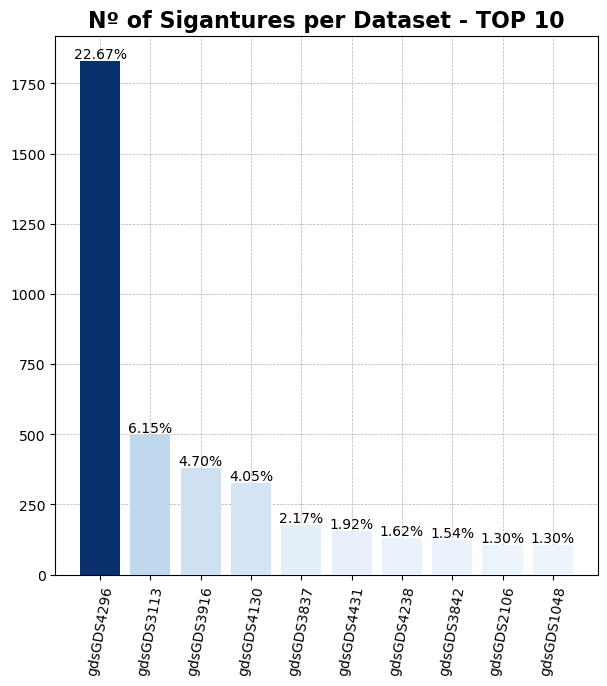

In [5]:
# get data for plot
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))

# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap("Blues")

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)

plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Dataset - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_datasets.png", dpi=300, bbox_inches="tight"
)

In [28]:
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

{}

In [82]:
with open("../data/iLINCS/dataset_2_mesh.json", "r") as f:
    d_dataset_2_mesh_original = json.load(f)

In [77]:
mesh_term_2_symbol["Biomarkers"]

['D23.101']

In [68]:
mesh_term_2_symbol, mesh_symbol_2_term = build_mesh_term_tree_number_mapping(
    mesh_file_path
)

In [90]:
failed_translation_all = list()
d_dataset_2_mesh = dict()

for k, MeSH_terms in d_dataset_2_mesh_original.items():
    tree_symbols = list()
    terms = list()
    failed_translation = list()
    d_dataset_2_mesh[k] = dict()

    for MeSH_term in MeSH_terms[0]:
        try:
            tree_symbols.extend(mesh_term_2_symbol[MeSH_term])
            terms.append(MeSH_term)
            # print(mesh_term_2_symbol[MeSH_term])
        except:
            failed_translation.append(MeSH_term)
            failed_translation_all.append(MeSH_term)
    d_dataset_2_mesh[k]["symbol"] = tree_symbols
    d_dataset_2_mesh[k]["terms"] = terms

In [93]:
level = 0
level_split = level * 4 + 3
all_symbols = list()
filter_criteria = lambda t: t.startswith("C")
for k in d_dataset_2_mesh.keys():
    if d_dataset_2_mesh[k]["symbol"] is not None:
        terms = d_dataset_2_mesh[k]["symbol"]

        terms_specific_level = list(set([t[:level_split] for t in terms if ]))
        all_symbols.extend(terms_specific_level)


# translate terms
all_terms = [mesh_symbol_2_term[s] for s in all_symbols]

In [94]:
all_terms

['Equipment and Supplies',
 'Digestive System',
 'Investigative Techniques',
 'Diagnosis',
 'Tissues',
 'Amino Acids, Peptides, and Proteins',
 'Biological Factors',
 'Surgical Procedures, Operative',
 'Cells',
 'Enzymes and Coenzymes',
 'Genetic Phenomena',
 'Natural Science Disciplines',
 'Eukaryota',
 'Respiratory System',
 'Macromolecular Substances',
 'Physical Phenomena',
 'Lipids',
 'Carbohydrates',
 'Cell Physiological Phenomena',
 'Investigative Techniques',
 'Chemical Actions and Uses',
 'Physiological Phenomena',
 'Pathological Conditions, Signs and Symptoms',
 'Amino Acids, Peptides, and Proteins',
 'Biological Factors',
 'Cells',
 'Nucleic Acids, Nucleotides, and Nucleosides',
 'Genetic Phenomena',
 'Eukaryota',
 'Immune System Phenomena',
 'Investigative Techniques',
 'Health Care Quality, Access, and Evaluation',
 'Environment and Public Health',
 'Hemic and Lymphatic Diseases',
 'Pathological Conditions, Signs and Symptoms',
 'Immune System Diseases',
 'Amino Acids, Pep

In [44]:
for k in d_signature_2_mesh.keys():
    if d_signature_2_mesh[k]["symbol"] is not None:
        terms = d_signature_2_mesh[k]["symbol"]
        terms_specific_level = list(set([t[:level_split] for t in terms]))
        all_symbols.extend(terms_specific_level)

{'GDS_120': {'symbol': None,
  'failed': None,
  'terms': None,
  'level1': 'early_stage_',
  'level2': 'normal',
  'datasetid': 'gdsGDS1070'},
 'GDS_123': {'symbol': None,
  'failed': None,
  'terms': None,
  'level1': 'late_stage_with_local_recurrence',
  'level2': 'normal',
  'datasetid': 'gdsGDS1070'},
 'GDS_125': {'symbol': None,
  'failed': None,
  'terms': None,
  'level1': 'late_stage_with_metastasis',
  'level2': 'normal',
  'datasetid': 'gdsGDS1070'},
 'GDS_126': {'symbol': None,
  'failed': None,
  'terms': None,
  'level1': 'late_stage_with_no_metastasis',
  'level2': 'normal',
  'datasetid': 'gdsGDS1070'},
 'GDS_148': {'symbol': None,
  'failed': None,
  'terms': None,
  'level1': 'breast_cancer',
  'level2': 'control',
  'datasetid': 'gdsGDS3716'},
 'GDS_149': {'symbol': None,
  'failed': None,
  'terms': None,
  'level1': 'asthma_atopic',
  'level2': 'healthy_non-atopic',
  'datasetid': 'gdsGDS3711'},
 'GDS_151': {'symbol': None,
  'failed': None,
  'terms': None,
  'lev

In [42]:
import matplotlib.pyplot as plt
from collections import Counter


# Count the occurrences of each category
category_counts = Counter(all_terms)


# Sort the categories by count in descending order
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels, values = zip(*sorted_categories)

# Create the bar plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 14), dpi=300)
plt.bar(labels, values, color="skyblue", zorder=3)

# Add title and labels to the plot
# plt.title('MeSH Term Counts Hierarchy Level %d' %level,fontsize=22)

# Manually add a title-like text above the y-axis label
ax.text(
    -0.1,
    1,
    "MeSH Root Term Counts",
    fontsize=22,
    transform=ax.transAxes,
    fontweight="bold",
    va="top",
    ha="right",
    rotation=90,
)

plt.ylabel("Counts", fontsize=12)

# Add grid lines with a white background
ax.set_facecolor("white")  # Set the background color to white

# plt.grid(axis='y', color='r', linestyle='--', alpha=0.7)
plt.grid(color="grey", linestyle="--", alpha=0.7, zorder=1)

# Add edges
ax.spines["bottom"].set_color("0")
ax.spines["top"].set_color("0")
ax.spines["right"].set_color("0")
ax.spines["left"].set_color("0")

# Rotate the category labels for better readability (if needed)
plt.yticks(rotation=90, va="center", fontsize=15)


# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha="right", fontsize=15, fontweight="bold")

# Show the plot
plt.tight_layout()  # Adjust the padding between and around subplots.
# plt.savefig("../results/figures/iLINCS/MeSH_Categories.png")

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# plot MeSH terms for datasets!

## c) Numbers for factors


In [6]:
from collections import Counter
import matplotlib.cm as cm


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot = Counter([s["factor"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Factors: {len(set(data_plot))}")

Nº of Unique Factors: 22


/tmp/ipykernel_26381/1982852845.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


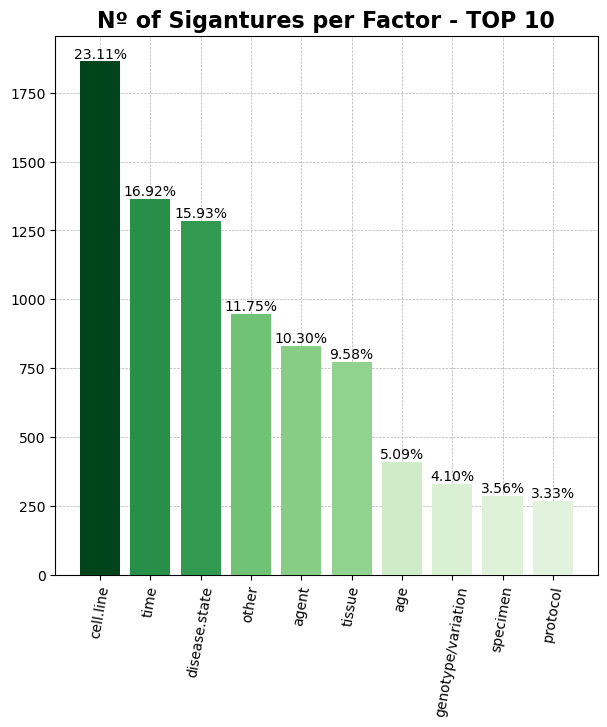

In [7]:
# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Greens"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Factor - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_factors.png", dpi=300, bbox_inches="tight"
)

## d) Numbers for conditions

In [8]:
from collections import Counter
import matplotlib.cm as cm


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot_ = [s["level1"] for s in signatures if s["libraryid"] == "LIB_1"]
data_plot_.extend([s["level2"] for s in signatures if s["libraryid"] == "LIB_1"])

print(f"Nº of Unique Conditions: {len(set(data_plot))}")

Nº of Unique Conditions: 22


/tmp/ipykernel_26381/1541039538.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


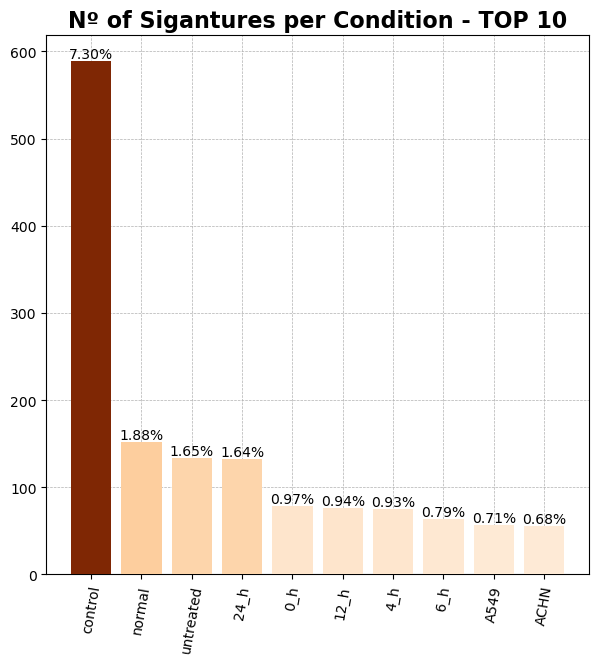

In [9]:
data_plot = Counter(data_plot_)

# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Oranges"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Condition - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
plt.savefig(
    "../results/figures/iLINCS/numbers/n_conditions.png", dpi=300, bbox_inches="tight"
)

## Nº Conditions per Factor

In [17]:
from collections import Counter
import matplotlib.cm as cm


# plot Nº of datasets!
def sort_dict(d_data):
    # Alternative way to sort the dictionary by values in descending order without using lambda
    x = sorted(d_data, key=d_data.get, reverse=True)
    y = [d_data[key] for key in x]

    return x, y


# Define Data of interest
data_plot_ = [
    s["level1"]
    for s in signatures
    if (s["libraryid"] == "LIB_1") and (s["factor"] == "cell.line")
]
data_plot_.extend(
    [
        s["level2"]
        for s in signatures
        if s["libraryid"] == "LIB_1" and (s["factor"] == "cell.line")
    ]
)

print(f"Nº of Unique Conditions: {len(set(data_plot))}")

Nº of Unique Conditions: 239


/tmp/ipykernel_26381/2325226783.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(


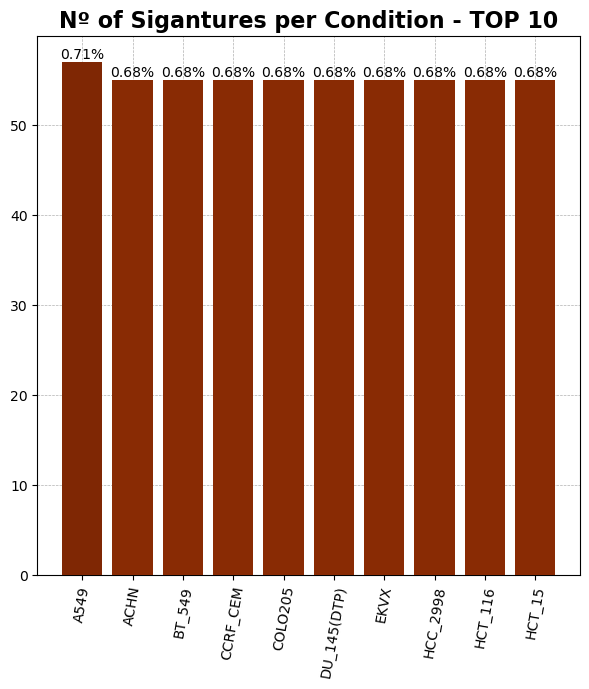

In [18]:
data_plot = Counter(data_plot_)

# Define values
x, y = sort_dict(data_plot)

# plot
plt.figure(figsize=(7, 7))


# Calculate relative heights (normalized to the range [0, 1])
relative_heights = y[:10] / np.max(y[:10])

# Choose a colormap
cmap = cm.get_cmap(
    "Oranges"
)  # You can choose different colormaps like 'Reds', 'Greens', etc.

# Creating the bar plot with gradient effect
bars = plt.bar(
    x[:10], y[:10], color=[cmap(height) for height in relative_heights], zorder=3
)


plt.xticks(rotation=80)
plt.title(
    "Nº of Sigantures per Condition - TOP 10",
    fontsize=16,
    fontweight="bold",
)

# Adding data labels on each bar
for bar in bars:
    yval = bar.get_height()
    yval_perc = yval / 9087 * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval,
        f"{yval/8067*100:.2f}%",
        verticalalignment="bottom",
        ha="center",
    )


# Optional: Adding grid lines
plt.grid(True, which="both", linestyle="--", linewidth=0.5, zorder=-2)
# plt.savefig(
#     "../results/figures/iLINCS/numbers/n_conditions.png", dpi=300, bbox_inches="tight"
# )

In [24]:
import requests
import json


def query_cellosaurus(cell_line):
    # Cellosaurus API endpoint for querying a specific cell line
    url = f"https://web.expasy.org/cgi-bin/cellosaurus/api/cell-line/{cell_line}?format=json"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Extracting disease information, assuming it's under a key like 'disease' or similar
        # The exact key name should be checked in the API response or documentation
        disease = data.get("disease", {}).get(
            "name", "Disease information not available"
        )
        return disease
    else:
        return f"Error querying Cellosaurus: {response.status_code}"


# Example usage
cell_line_disease = query_cellosaurus("A549")
print(cell_line_disease)

<Response [404]>
Error querying Cellosaurus: 404
